In [1]:
import numpy as np
import h5py
import os, sys
import argparse
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score
from sklearn.metrics import confusion_matrix
from PlottingFunctions import plot_bin_slices

In [2]:
import matplotlib.colors as colors

In [3]:
input_file = "/mnt/home/micall12/LowEnergyNeuralNetwork/output_plots/L7_oscNext/prediction_values_1201h_1401h_16.5h_1318k19k.hdf5"
no_old_reco = False
numu_files = 97
nue_files = 91
nutau_files = 100
muon_files = 2000

f = h5py.File(input_file, "r")
truth = f["Y_test_use"][:]
predict = f["Y_predicted"][:]
try:
    info = f["additional_info"][:]
except:
    info = None
if no_old_reco:
    reco = None
else:
    try:
        reco = f["reco_test"][:]
    except:
        reco = None
try:
    weights = f["weights_test"][:]
except:
    weights = None
f.close()
del f

In [4]:
cnn_x = np.array(predict[:,3])
cnn_y = np.array(predict[:,4])
cnn_z = np.array(predict[:,5])

retro_x = np.array(reco[:,4])
retro_y = np.array(reco[:,5])
retro_z = np.array(reco[:,6])

true_x = np.array(truth[:,4])
true_y = np.array(truth[:,5])
true_z = np.array(truth[:,6])

x_origin = np.ones((len(true_x)))*46.290000915527344
y_origin = np.ones((len(true_y)))*-34.880001068115234
true_r = np.sqrt( (true_x - x_origin)**2 + (true_y - y_origin)**2 )
cnn_r = np.sqrt( (cnn_x - x_origin)**2 + (cnn_y - y_origin)**2 )
retro_r = np.sqrt( (retro_x - x_origin)**2 + (retro_y - y_origin)**2 )

In [5]:
true_CC = np.array(truth[:,11])
true_isCC = true_CC == 1
true_PID = np.array(truth[:,9])

muon_mask_test = (true_PID) == 13
true_isMuon = np.array(muon_mask_test,dtype=bool)
numu_mask_test = (true_PID) == 14
true_isNuMu = np.array(numu_mask_test,dtype=bool)
nue_mask_test = (true_PID) == 12
true_isNuE = np.array(nue_mask_test,dtype=bool)
nutau_mask_test = (true_PID) == 16
true_isNuTau = np.array(nutau_mask_test,dtype=bool)
nu_mask = np.logical_or(np.logical_or(numu_mask_test, nue_mask_test), nutau_mask_test)
true_isNu = np.array(nu_mask,dtype=bool)

In [6]:
if weights is not None:
    weights = weights[:,8]
    if sum(true_isNuMu) > 1:
        #print("NuMu:",sum(true_isNuMu),sum(weights[true_isNuMu]))
        weights[true_isNuMu] = weights[true_isNuMu]/numu_files
        #print(sum(weights[true_isNuMu]))
    if sum(true_isNuE) > 1:
        #print("NuE:",sum(true_isNuE),sum(weights[true_isNuE]))
        weights[true_isNuE] = weights[true_isNuE]/nue_files
        #print(sum(weights[true_isNuE]))
    if sum(muon_mask_test) > 1:
        #print("Muon:",sum(true_isMuon),sum(weights[true_isMuon]))
        weights[true_isMuon] = weights[true_isMuon]/muon_files
        #print(sum(weights[true_isMuon]))
    if sum(nutau_mask_test) > 1:
        #print("NuTau:",sum(true_isNuTau),sum(weights[true_isNuTau]))
        weights[true_isNuTau] = weights[true_isNuTau]/nutau_files
        #print(sum(weights[true_isNuTau]))

In [7]:
zmin_cut = -495
zmax_cut = -225
rmax_cut = 165

In [109]:
a_mask_here = true_isNuMu #np.logical_and(true_isCC, true_isNuMu)
weights_here = weights[a_mask_here]
cnn_rcut = cnn_r[a_mask_here] < 165
retro_rcut = retro_r[a_mask_here] < 165
true_rcut = true_r[a_mask_here] < 165
print("R Cut: CNN, Retro, True")
print(sum(cnn_rcut), sum(retro_rcut), sum(true_rcut))
print(sum(weights_here[cnn_rcut]), sum(weights_here[retro_rcut]), sum(weights_here[true_rcut]))
cnn_zcut = np.logical_and(cnn_z[a_mask_here] > -495, cnn_z[a_mask_here] < -225)
retro_zcut = np.logical_and(retro_z[a_mask_here] > -495, retro_z[a_mask_here] < -225)
true_zcut = np.logical_and(true_z[a_mask_here] > -495, true_z[a_mask_here] < -225)
print("Z Cut: CNN, Retro, True")
print(sum(cnn_zcut), sum(retro_zcut), sum(true_zcut))
print(sum(weights_here[cnn_zcut]), sum(weights_here[retro_zcut]), sum(weights_here[true_zcut]))


R Cut: CNN, Retro, True
267069 271114 264881
0.0014084192553895447 0.00143042813504057 0.0013864833856407411
Z Cut: CNN, Retro, True
252831 263926 261202
0.0013399144646328214 0.0013984006312621486 0.0013880146874952505


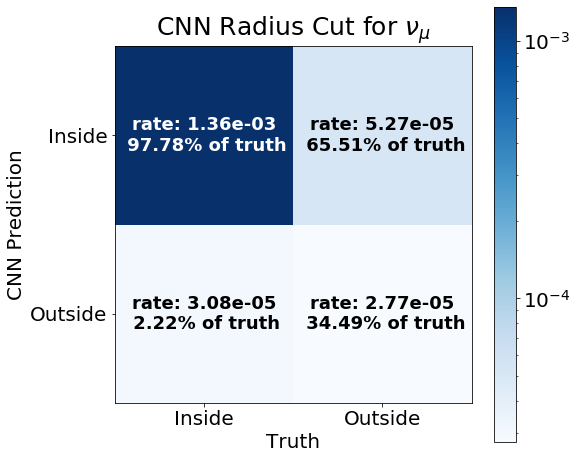

In [110]:
cm = confusion_matrix(true_rcut, cnn_rcut, sample_weight=weights_here)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
blues=plt.get_cmap('Blues')
minval = np.min(cm)
maxval = np.max(cm)

invert_true_rcut = np.invert(true_rcut)
hist, xbins, ybins, im = ax.hist2d(invert_true_rcut, cnn_rcut, bins=2,cmap=blues,weights=weights_here,
                                    norm=colors.LogNorm(vmin=minval, vmax=maxval))
fig.colorbar(im, orientation='vertical')
plt.yticks(ticks=[0.25,0.75],labels=["Outside", "Inside"])
plt.xticks(ticks=[0.25,0.75],labels=["Inside", "Outside"])
ax.set_ylabel("CNN Prediction",fontsize=20)
ax.set_xlabel("Truth",fontsize=20)
ax.set_title(r'CNN Radius Cut for $\nu_\mu$',fontsize=25)



for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        c="k"
        if j == 0:
            total = sum(weights_here[true_rcut])
            if i == 1:
                c="w"
        if j == 1:
            not_true = np.invert(true_rcut)
            total = sum(weights_here[not_true])
        events = hist.T[i,j]
        percent = (float(events)/float(total))*100
        s = "rate: %.2e\n %.2f"%(events,percent) + '% of truth'
        ax.text(xbins[j]+0.25,ybins[i]+0.25,"%s"%s, 
                color=c, ha="center", va="center", fontweight="bold",fontsize=18)

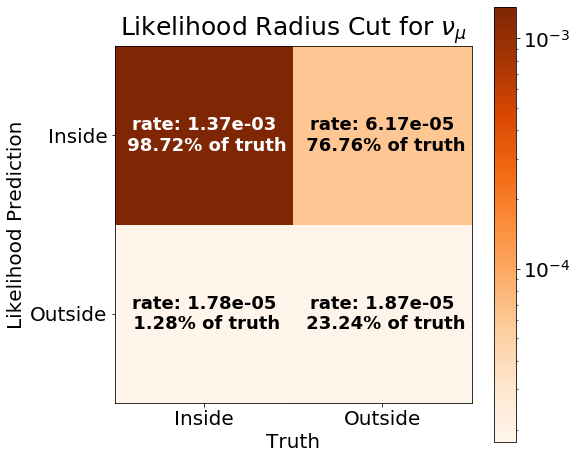

In [111]:
cm = confusion_matrix(true_rcut, retro_rcut, sample_weight=weights_here)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
blues=plt.get_cmap('Oranges')
minval = np.min(cm)
maxval = np.max(cm)

invert_true_rcut = np.invert(true_rcut)
hist, xbins, ybins, im = ax.hist2d(invert_true_rcut, retro_rcut, bins=2,cmap=blues,weights=weights_here,
                                    norm=colors.LogNorm(vmin=minval, vmax=maxval))
fig.colorbar(im, orientation='vertical')
plt.yticks(ticks=[0.25,0.75],labels=["Outside", "Inside"])
plt.xticks(ticks=[0.25,0.75],labels=["Inside", "Outside"])
ax.set_ylabel("Likelihood Prediction",fontsize=20)
ax.set_xlabel("Truth",fontsize=20)
ax.set_title(r'Likelihood Radius Cut for $\nu_\mu$',fontsize=25)

for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        c="k"
        if j == 0:
            total = sum(weights_here[true_rcut])
            if i == 1:
                c="w"
        if j == 1:
            not_true = np.invert(true_rcut)
            total = sum(weights_here[not_true])
        events = hist.T[i,j]
        percent = (float(events)/float(total))*100
        s = "rate: %.2e\n %.2f"%(events,percent) + '% of truth'
        ax.text(xbins[j]+0.25,ybins[i]+0.25,"%s"%s, 
                color=c, ha="center", va="center", fontweight="bold",fontsize=18)

In [100]:
a_mask_here = true_isNuE #np.logical_and(true_isCC, true_isNuMu)
weights_here = weights[a_mask_here]
cnn_rcut = cnn_r[a_mask_here] < 165
retro_rcut = retro_r[a_mask_here] < 165
true_rcut = true_r[a_mask_here] < 165
print("R Cut: CNN, Retro, True")
print(sum(cnn_rcut), sum(retro_rcut), sum(true_rcut))
print(sum(weights_here[cnn_rcut]), sum(weights_here[retro_rcut]), sum(weights_here[true_rcut]))
cnn_zcut = np.logical_and(cnn_z[a_mask_here] > -495, cnn_z[a_mask_here] < -225)
retro_zcut = np.logical_and(retro_z[a_mask_here] > -495, retro_z[a_mask_here] < -225)
true_zcut = np.logical_and(true_z[a_mask_here] > -495, true_z[a_mask_here] < -225)
print("Z Cut: CNN, Retro, True")
print(sum(cnn_zcut), sum(retro_zcut), sum(true_zcut))
print(sum(weights_here[cnn_zcut]), sum(weights_here[retro_zcut]), sum(weights_here[true_zcut]))


R Cut: CNN, Retro, True
278020 279130 280454
0.0004532462681955726 0.00045421176367835666 0.00045635198204542796
Z Cut: CNN, Retro, True
261531 272129 272781
0.0004293802302114559 0.0004446824723697693 0.0004463803314187098


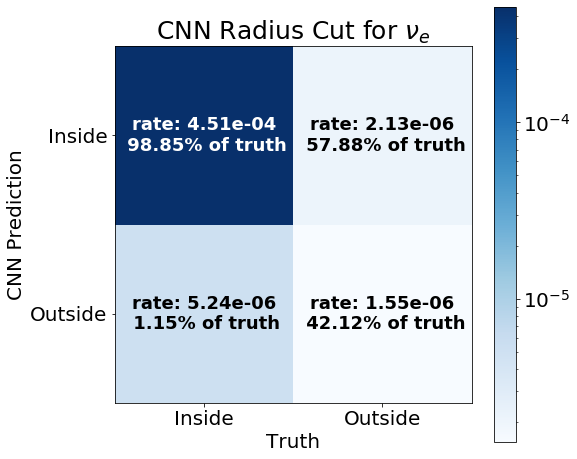

In [108]:
cm = confusion_matrix(true_rcut, cnn_rcut, sample_weight=weights_here)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
blues=plt.get_cmap('Blues')
minval = np.min(cm)
maxval = np.max(cm)

invert_true_rcut = np.invert(true_rcut)
hist, xbins, ybins, im = ax.hist2d(invert_true_rcut, cnn_rcut, bins=2,cmap=blues,weights=weights_here,
                                    norm=colors.LogNorm(vmin=minval, vmax=maxval))
fig.colorbar(im, orientation='vertical')
plt.yticks(ticks=[0.25,0.75],labels=["Outside", "Inside"])
plt.xticks(ticks=[0.25,0.75],labels=["Inside", "Outside"])
ax.set_ylabel("CNN Prediction",fontsize=20)
ax.set_xlabel("Truth",fontsize=20)
ax.set_title(r'CNN Radius Cut for $\nu_e$',fontsize=25)



for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        c="k"
        if j == 0:
            total = sum(weights_here[true_rcut])
            if i == 1:
                c="w"
        if j == 1:
            not_true = np.invert(true_rcut)
            total = sum(weights_here[not_true])
        events = hist.T[i,j]
        percent = (float(events)/float(total))*100
        s = "rate: %.2e\n %.2f"%(events,percent) + '% of truth'
        ax.text(xbins[j]+0.25,ybins[i]+0.25,"%s"%s, 
                color=c, ha="center", va="center", fontweight="bold",fontsize=18)

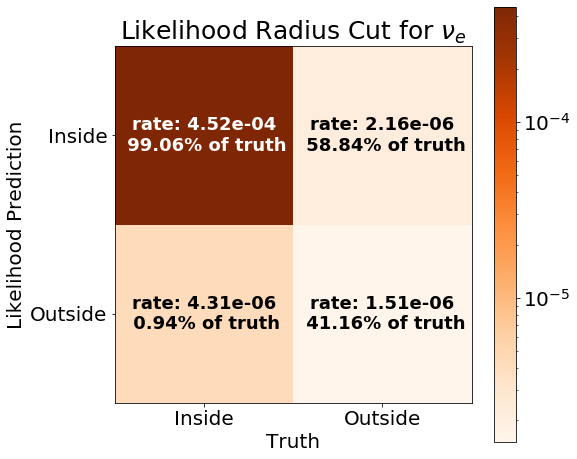

In [106]:
cm = confusion_matrix(true_rcut, retro_rcut, sample_weight=weights_here)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
blues=plt.get_cmap('Oranges')
minval = np.min(cm)
maxval = np.max(cm)

invert_true_rcut = np.invert(true_rcut)
hist, xbins, ybins, im = ax.hist2d(invert_true_rcut, retro_rcut, bins=2,cmap=blues,weights=weights_here,
                                    norm=colors.LogNorm(vmin=minval, vmax=maxval))
fig.colorbar(im, orientation='vertical')
plt.yticks(ticks=[0.25,0.75],labels=["Outside", "Inside"])
plt.xticks(ticks=[0.25,0.75],labels=["Inside", "Outside"])
ax.set_ylabel("Likelihood Prediction",fontsize=20)
ax.set_xlabel("Truth",fontsize=20)
ax.set_title(r'Likelihood Radius Cut for $\nu_e$',fontsize=25)

for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        c="k"
        if j == 0:
            total = sum(weights_here[true_rcut])
            if i == 1:
                c="w"
        if j == 1:
            not_true = np.invert(true_rcut)
            total = sum(weights_here[not_true])
        events = hist.T[i,j]
        percent = (float(events)/float(total))*100
        s = "rate: %.2e\n %.2f"%(events,percent) + '% of truth'
        ax.text(xbins[j]+0.25,ybins[i]+0.25,"%s"%s, 
                color=c, ha="center", va="center", fontweight="bold",fontsize=18)

In [8]:
a_mask_here = np.logical_or(true_isNuMu, true_isNuE) #np.logical_and(true_isCC, true_isNuMu)
weights_here = weights[a_mask_here]
cnn_rcut = cnn_r[a_mask_here] < 165
retro_rcut = retro_r[a_mask_here] < 165
true_rcut = true_r[a_mask_here] < 165
print("R Cut: CNN, Retro, True")
print(sum(cnn_rcut), sum(retro_rcut), sum(true_rcut))
print(sum(weights_here[cnn_rcut]), sum(weights_here[retro_rcut]), sum(weights_here[true_rcut]))
cnn_zcut = np.logical_and(cnn_z[a_mask_here] > -495, cnn_z[a_mask_here] < -225)
retro_zcut = np.logical_and(retro_z[a_mask_here] > -495, retro_z[a_mask_here] < -225)
true_zcut = np.logical_and(true_z[a_mask_here] > -495, true_z[a_mask_here] < -225)
print("Z Cut: CNN, Retro, True")
print(sum(cnn_zcut), sum(retro_zcut), sum(true_zcut))
print(sum(weights_here[cnn_zcut]), sum(weights_here[retro_zcut]), sum(weights_here[true_zcut]))
cnn_cuts = np.logical_and(cnn_zcut, cnn_rcut)
retro_cuts = np.logical_and(retro_zcut, retro_rcut)
true_cuts = np.logical_and(true_zcut, true_rcut)

R Cut: CNN, Retro, True
545089 550244 545335
0.0018616655235851503 0.0018846398987189673 0.0018428353676861991
Z Cut: CNN, Retro, True
514362 536055 533983
0.0017692946948443028 0.0018430831036319554 0.0018343950189139934


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


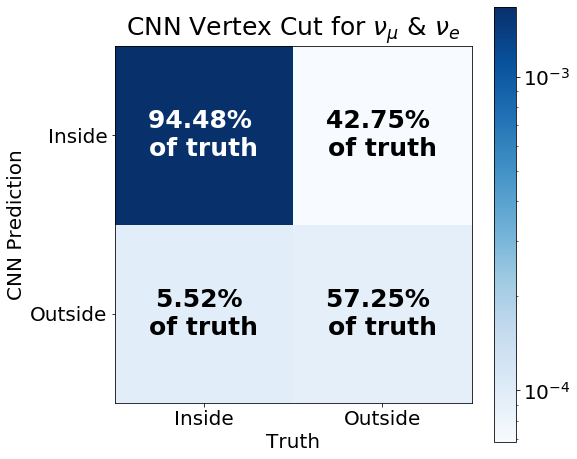

In [9]:
cm = confusion_matrix(true_cuts, cnn_cuts, sample_weight=weights_here)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
blues=plt.get_cmap('Blues')
minval = np.min(cm)
maxval = np.max(cm)

invert_true_cuts = np.invert(true_cuts)
hist, xbins, ybins, im = ax.hist2d(invert_true_cuts, cnn_cuts, bins=2,cmap=blues,weights=weights_here,
                                    norm=colors.LogNorm(vmin=minval, vmax=maxval))
fig.colorbar(im, orientation='vertical')
plt.yticks(ticks=[0.25,0.75],labels=["Outside", "Inside"])
plt.xticks(ticks=[0.25,0.75],labels=["Inside", "Outside"])
ax.set_ylabel("CNN Prediction",fontsize=20)
ax.set_xlabel("Truth",fontsize=20)
ax.set_title(r'CNN Vertex Cut for $\nu_\mu$ & $\nu_e$',fontsize=25)



for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        c="k"
        if j == 0:
            total = sum(weights_here[true_cuts])
            if i == 1:
                c="w"
        if j == 1:
            not_true = np.invert(true_cuts)
            total = sum(weights_here[not_true])
        events = hist.T[i,j]
        percent = (float(events)/float(total))*100
        s = "%.2f"%(percent) + '% \nof truth'
        ax.text(xbins[j]+0.25,ybins[i]+0.25,"%s"%s, 
                color=c, ha="center", va="center", fontweight="bold",fontsize=25)

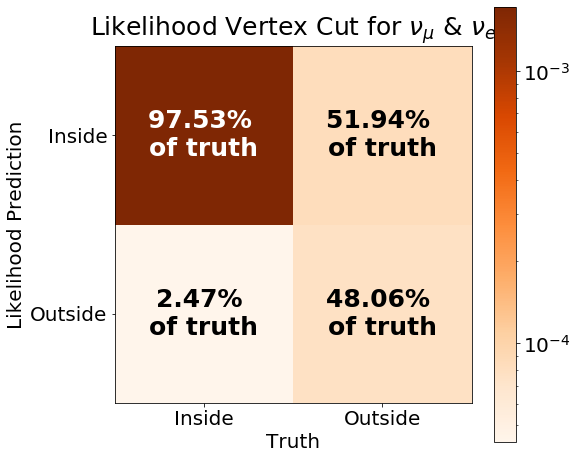

In [10]:
cm = confusion_matrix(true_cuts, retro_cuts, sample_weight=weights_here)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
blues=plt.get_cmap('Oranges')
minval = np.min(cm)
maxval = np.max(cm)

invert_true_cuts = np.invert(true_cuts)
hist, xbins, ybins, im = ax.hist2d(invert_true_cuts, retro_cuts, bins=2,cmap=blues,weights=weights_here,
                                    norm=colors.LogNorm(vmin=minval, vmax=maxval))
fig.colorbar(im, orientation='vertical')
plt.yticks(ticks=[0.25,0.75],labels=["Outside", "Inside"])
plt.xticks(ticks=[0.25,0.75],labels=["Inside", "Outside"])
ax.set_ylabel("Likelihood Prediction",fontsize=20)
ax.set_xlabel("Truth",fontsize=20)
ax.set_title(r'Likelihood Vertex Cut for $\nu_\mu$ & $\nu_e$',fontsize=25)

for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        c="k"
        if j == 0:
            total = sum(weights_here[true_cuts])
            if i == 1:
                c="w"
        if j == 1:
            not_true = np.invert(true_cuts)
            total = sum(weights_here[not_true])
        events = hist.T[i,j]
        percent = (float(events)/float(total))*100
        s = "%.2f"%(percent) + '% \nof truth'
        ax.text(xbins[j]+0.25,ybins[i]+0.25,"%s"%s, 
                color=c, ha="center", va="center", fontweight="bold",fontsize=25)

In [14]:
true_energy = np.array(truth[:,0])
true_zenith = np.array(truth[:,12])
true_coszenith = np.cos(np.array(truth[:,12]))

retro_energy = np.array(reco[:,0])
retro_zenith = np.array(reco[:,1])
retro_coszen = np.cos(retro_zenith)

cnn_energy = np.array(predict[:,0])
cnn_zenith = np.array(predict[:,1])
cnn_coszen = np.cos(cnn_zenith)

In [28]:
cnn_rcut = cnn_r < 165
retro_rcut = retro_r < 165
true_rcut = true_r < 165

cnn_zcut = np.logical_and(cnn_z > -495, cnn_z < -225)
retro_zcut = np.logical_and(retro_z > -495, retro_z < -225)
true_zcut = np.logical_and(true_z > -495, true_z < -225)

cnn_cuts = np.logical_and(cnn_zcut, cnn_rcut)
retro_cuts = np.logical_and(retro_zcut, retro_rcut)
true_cuts = np.logical_and(true_zcut, true_rcut)

mask_cnn = np.logical_and(true_isNuMu, cnn_cuts)
mask_retro = np.logical_and(true_isNuMu, retro_cuts)

In [32]:
from PlottingFunctions import plot_bin_slices
plot_bin_slices(true_coszenith[mask_cnn],
                            cnn_coszen[mask_cnn],
                            weights=weights[mask_cnn],
                            energy_truth = true_energy[mask_cnn],
                            old_reco = retro_coszen[mask_retro],
                            old_reco_truth = retro_coszen[mask_retro],
                            reco_energy_truth = retro_energy[mask_retro],
                            old_reco_weights = weights[mask_retro],
                            vs_predict = False,reco_name="Likelihood",
                            use_fraction = False, bins=20,
                            min_val=1, max_val=200,\
                            save=True, savefolder="/mnt/home/micall12/LowEnergyNeuralNetwork/output_plots/L7_oscNext/Vertex_Compare/",
                            variable="Cosine Zenith", units="(GeV)",
                            xvariable="True Energy",
                            flavor="NuMu",sample="CC")

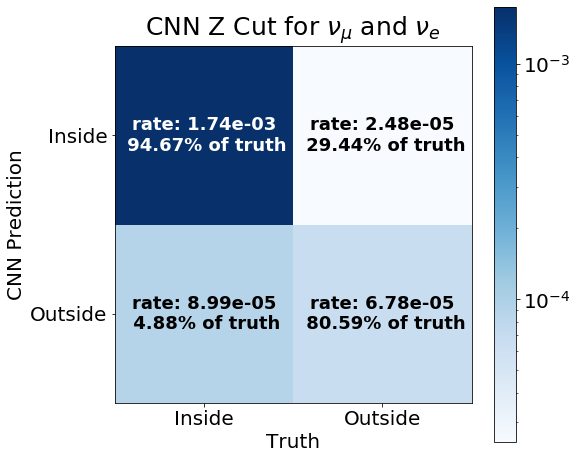

In [116]:
cm = confusion_matrix(true_zcut, cnn_zcut, sample_weight=weights_here)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
blues=plt.get_cmap('Blues')
minval = np.min(cm)
maxval = np.max(cm)

invert_true_zcut = np.invert(true_zcut)
hist, xbins, ybins, im = ax.hist2d(invert_true_zcut, cnn_zcut, bins=2,cmap=blues,weights=weights_here,
                                    norm=colors.LogNorm(vmin=minval, vmax=maxval))
fig.colorbar(im, orientation='vertical')
plt.yticks(ticks=[0.25,0.75],labels=["Outside", "Inside"])
plt.xticks(ticks=[0.25,0.75],labels=["Inside", "Outside"])
ax.set_ylabel("CNN Prediction",fontsize=20)
ax.set_xlabel("Truth",fontsize=20)
ax.set_title(r'CNN Z Cut for $\nu_\mu$ and $\nu_e$',fontsize=25)



for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        c="k"
        if j == 0:
            total = sum(weights_here[true_rcut])
            if i == 1:
                c="w"
        if j == 1:
            not_true = np.invert(true_rcut)
            total = sum(weights_here[not_true])
        events = hist.T[i,j]
        percent = (float(events)/float(total))*100
        s = "rate: %.2e\n %.2f"%(events,percent) + '% of truth'
        ax.text(xbins[j]+0.25,ybins[i]+0.25,"%s"%s, 
                color=c, ha="center", va="center", fontweight="bold",fontsize=18)

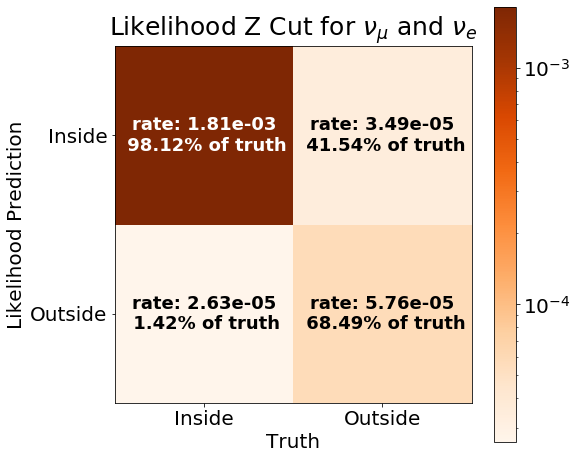

In [118]:
cm = confusion_matrix(true_zcut, retro_zcut, sample_weight=weights_here)

fig, ax = plt.subplots(figsize=(8,8))
ax.set_aspect("equal")
blues=plt.get_cmap('Oranges')
minval = np.min(cm)
maxval = np.max(cm)

invert_true_zcut = np.invert(true_zcut)
hist, xbins, ybins, im = ax.hist2d(invert_true_zcut, retro_zcut, bins=2,cmap=blues,weights=weights_here,
                                    norm=colors.LogNorm(vmin=minval, vmax=maxval))
fig.colorbar(im, orientation='vertical')
plt.yticks(ticks=[0.25,0.75],labels=["Outside", "Inside"])
plt.xticks(ticks=[0.25,0.75],labels=["Inside", "Outside"])
ax.set_ylabel("Likelihood Prediction",fontsize=20)
ax.set_xlabel("Truth",fontsize=20)
ax.set_title(r'Likelihood Z Cut for $\nu_\mu$ and $\nu_e$',fontsize=25)



for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        c="k"
        if j == 0:
            total = sum(weights_here[true_rcut])
            if i == 1:
                c="w"
        if j == 1:
            not_true = np.invert(true_rcut)
            total = sum(weights_here[not_true])
        events = hist.T[i,j]
        percent = (float(events)/float(total))*100
        s = "rate: %.2e\n %.2f"%(events,percent) + '% of truth'
        ax.text(xbins[j]+0.25,ybins[i]+0.25,"%s"%s, 
                color=c, ha="center", va="center", fontweight="bold",fontsize=18)